In [16]:
import sys
from pathlib import Path
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import HumanMessage, ToolMessage, SystemMessage

sys.path.append(str(Path().cwd().parent))

from llm_experiments.chat import instantiate_chat


@tool
def round_number(n: float, precision: int) -> int:
    """add two numbers together"""
    return round(n, precision)


model = instantiate_chat("4o-mini")
tools = [round_number]
tools_by_name = {t.name: t for t in tools}
tooled_model = model.bind_tools(tools)


def llm_call(state: MessagesState):
    role = "you are a helpful assistant"
    messages = [
        tooled_model.invoke([SystemMessage(content=role), *state["messages"]])
    ]
    return {"messages": messages}


def tool_node(state: MessagesState):
    results = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        results.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": results}


def should_continue(state: MessagesState):
    if state["messages"][-1].tool_calls:
        return "action"
    else:
        return END


builder = StateGraph(MessagesState)

builder.add_node("llm_call", llm_call)
builder.add_node("environment", tool_node)

builder.add_edge(START, "llm_call")
builder.add_conditional_edges("llm_call", should_continue, {"action": "environment", END: END})
builder.add_edge("environment", "llm_call")

graph = builder.compile()

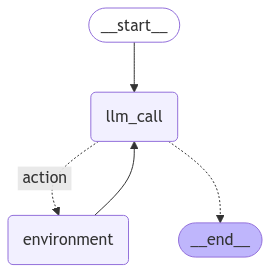

In [17]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))
query = "round 1.234 to 2 decimal places"

In [22]:
messages = graph.invoke({"messages": [HumanMessage(content=query)]})
for index, m in enumerate(messages["messages"]):
    print(index, m.content)

0 round 1.234 to 2 decimal places
1 
2 1.23
3 The number 1.234 rounded to two decimal places is 1.23.
